# Advanced Lane Line Detection
***

One important component of a self driving car is the ability to detect lane lines. Knowing where the lane lines are enables you to keep a car driving within its lane, and thereby minimize the chances of collisions with other cars. As humans, we are able to do this quite naturally. For computers, this isn't quite so easy. In this notebook, we demonstrate lane line detection using some well known computer vision techniques.  

---

## Admin

import packages

In [1]:
# standard packages
import numpy as np
import os

# image processing packages
import cv2

# visualization packages
import matplotlib.pyplot as plt

set params

In [2]:
# show plots inline
%matplotlib inline

---

## General Approach 

There are a number of ways to detect driving lanes from images and the following is one such (relatively simple) approach: 

1. Camera calibration
2. RGB to HSL
3. Gaussian blur
4. Thresholding
5. Warp perspective
6. Detect lane lines
7. Measuring curvature
8. Overlay unwarped detection on original image

We'll start by developing a pipeline using individual images. Later we show how this can easily be extended to videos (which are really just a series of images). We will use the following sample images for developing and testing our pipelines.  

In [3]:
test_img_dir = "test_images/"

original_image_names = (
    sorted(
        os.listdir(test_img_dir)
    )
)

original_image_names = list(
    map(lambda name: test_img_dir + name, 
        original_image_names))

In [4]:
def show_image_list(img_list, 
                    cols=2, 
                    fig_size=(10, 10),
                    img_labels=original_image_names, 
                    cmap=None):
    
    """
    Show a list of images
    """
    
    img_count = len(img_list)
    
    rows = np.ceil(img_count / cols)
    
    plt.figure(figsize=fig_size)
        
    for i in range(0, img_count):
        
        img_name = img_labels[i]
        
        plt.subplot(rows, cols, i+1)
        
        img = img_list[i]
                
        # no ticks on axes
        plt.xticks([])
        plt.yticks([])
        
        # plot title
        plt.title(img_name)    
        
        # show plot 
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

In [5]:
def load_image(image_path): 
    """
    load images in RGB format
    """
    
    imgBGR = cv2.imread(image_path)
    
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    return imgRGB

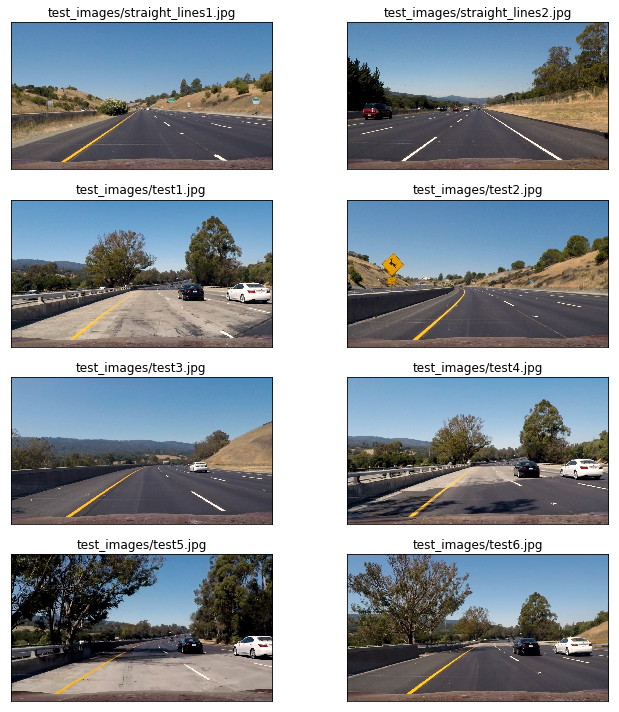

In [6]:
original_images = list(
    map(lambda img: load_image(img), 
        original_image_names)
)

show_image_list(img_list = original_images)

There are few immediately obvious challenges we need to be mindful of while building a generalized pipeline for deteting lanes in these images:  

1. Lane lines can be coloured both white and yellow. Note that some of the cars in these images are colored white!  
2. Lane lines can be broken and unbroken.     
3. Some lanes are curving while others are straight.   

For testing our pipeline, we'll use just the first image (shown below again for convenience).  

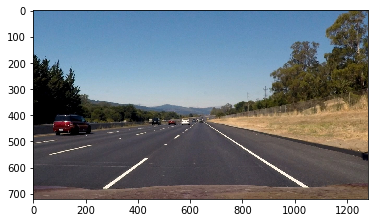

In [7]:
test_image = original_images[1]

plt.imshow(test_image)

---

## Step 1: Camera calibration

The process by which cameras produce 2D images of 3D objects isn't perfect; the shape and size of objects can change during the transformation. Below is an example of a distorted image taken by a camera (left) and the same image undistorted (right).  

<figure>
 <img src="writeup_images/chessboard_undistort.jpg"/>
 <figcaption>
 <p></p> 
     
For something as important as lane line detection, we need to be able to get accurate and useful information out of our images. To do that, we'll need to first deal with the distortion in our images. Specifically, we will use images of chessboards taken by our camera to figure out it's calibration parameters. Using those parameters, we can then undistort any image taken by our particular camera.  

In [8]:
# read in camera calibration images from directory

# img dir
camera_cal_img_dir = "camera_cal/"

# img names
camera_cal_image_names = (
    sorted(
        os.listdir(camera_cal_img_dir)
    )
)

# image paths
camera_cal_image_paths = list(
    map(lambda name: camera_cal_img_dir + name, 
        camera_cal_image_names)
)

# images
camera_cal_images = list(
    map(lambda img: load_image(img), 
        camera_cal_image_paths)
)

In [9]:
# show_image_list(
#     img_list = camera_cal_images,
#     img_labels = camera_cal_image_names, 
#     cols=5
# )

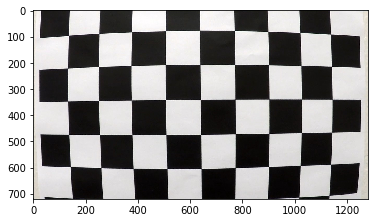

In [10]:
plt.imshow(camera_cal_images[0])

In [11]:
# grayscale images
gray_camera_cal_images = [
    cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in camera_cal_images
]

# set chessboard dimensions
dims = (9,6)

# find chessboard corners
chessboard_corners = [
    cv2.findChessboardCorners(image, dims, None) for image in gray_camera_cal_images
]

In [12]:
# verify chessboard corners have been correctly identified
# plt.imshow(
#     cv2.drawChessboardCorners(
#     camera_cal_images[0], 
#     dims, 
#     *chessboard_corners[0][::-1])
# )

Calculate correct camera matrix and distortion coefficients

In [13]:
# object points
objp = np.zeros(
    (np.prod(dims), 3), 
    np.float32
)

objp[:,:2] = np.mgrid[0:dims[0], 0:dims[1]].T.reshape(-1,2)

objpoints = [
    objp for corner_set in chessboard_corners if corner_set[0]
]

# image points
imgpoints = [
    corner_set[1] for corner_set in chessboard_corners if corner_set[0]
]

# extract camera calibration paramets
ret, mtx, dist, rvecs, tvecs = (
    cv2.calibrateCamera(
        objpoints, 
        imgpoints, 
        gray_camera_cal_images[0].shape[::-1], 
        None, 
        None)
)

In [14]:
def undistort(img, mtx, dist): 
    """
    undistort camera images
    """
    undistorted_img = cv2.undistort(
        img, 
        mtx, 
        dist, 
        None, 
        mtx
    )
    
    return undistorted_img

In [15]:
undistorted_camera_cal_images = list(
    map(lambda img: undistort(img, mtx, dist), 
        camera_cal_images)
)

In [16]:
# show_image_list(
#     img_list = undistorted_camera_cal_images,
#     img_labels = camera_cal_image_names, 
#     cols=5
# )

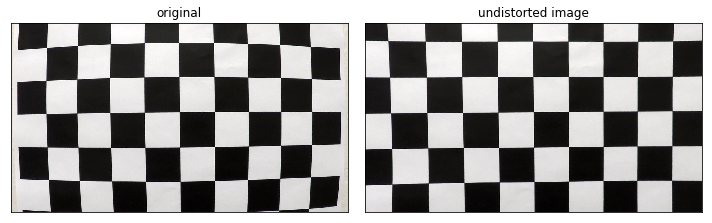

In [17]:
show_image_list(
    img_list=[
        camera_cal_images[0], undistorted_camera_cal_images[0], 
    ],
    img_labels=[
        'original', 'undistorted image'
    ], 
    cmap='gray',
    cols=2
)

Let's undistort our actual driving images. 

In [18]:
undistorted_image = undistort(
    img=test_image, 
    mtx=mtx, 
    dist=dist
)

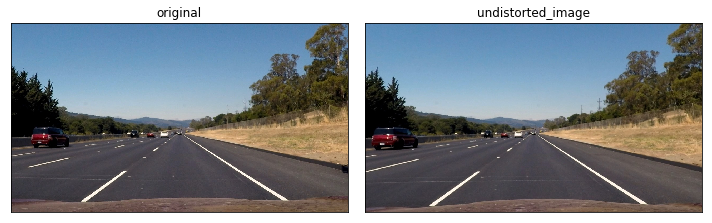

In [19]:
show_image_list(
    img_list=[
        test_image, undistorted_image, 
    ],
    img_labels=[
        'original', 'undistorted_image'
    ], 
    cmap='gray',
    cols=2
)

The difference here isn't immediately obvious but rest assured, the transformation is complete. In our test image, the lane lines are quite visible. In other images, where the road is covered by shadows, the lane lines are sometimes less clear. Next we explore one way of getting our lane lines to stand out even more clearly.  

---

## Step 2: Convert image to HSL

There are a number of color models, below is a brief introduction to two of the most popular models in use today.   

#### RGB 

The most commonly used model is the RGB model which defines a color space in terms of three components:

- Red, which ranges from 0-255
- Green, which ranges from 0-255
- Blue, which ranges from 0-255

The RGB color model is additive i.e. Red, Green and Blue values are combined to reproduce other colors. 

<figure>
 <img src="writeup_images/rgb.png" witdth = 500/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> RGB color model </p> 

#### HLS 

The HLS color space stands for:

- Hue : the color type (such as red, blue, or yellow). Ranges from 0 to 360° in most applications (each value corresponds to one color : 0 is red, 45 is a shade of orange and 55 is a shade of yellow).
- Lightness (also Luminance or Luminosity or Intensity). Ranges from 0 to 100% (from black to white).
- Saturation : variation of the color depending on the lightness. Ranges from 0 to 100% (from the center of the black&white axis).


<figure>
 <img src="writeup_images/hsl.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> HLS color model </p> 
     
#### HSV 

The HSV color space stands for:

- Hue : the color type (such as red, blue, or yellow). Ranges from 0 to 360° in most applications (each value corresponds to one color : 0 is red, 45 is a shade of orange and 55 is a shade of yellow).
- Saturation : variation of the color depending on the lightness. Ranges from 0 to 100% (from the center of the black&white axis).  
- Value (or Brightness): describes the brightness or intensity of the color, from 0-100 percent, where 0 is completely black and 100 is the brightest and reveals the most color.

<figure>
 <img src="writeup_images/hsv.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> HSV color model </p> 


There are other color models out there too including CMYK, and YUV. Like most images however, all of our images are in RBG format. So why are we talking about other color models? We suspect that it might be easier to isolate driving lanes in other color spaces than RGB. So let's have a look at our test images in HSL.    

In [20]:
def rgb(img_rgb, channel):
    """
    extracts specified channel from RGB image
    """
    
    if channel=='r':
        img_channel = img_rgb[:,:,0] 
    if channel=='g':
        img_channel = img_rgb[:,:,1]
    if channel=='b':
        img_channel = img_rgb[:,:,2]
    if channel==None:
        img_channel = img_rgb
    
    return img_channel

In [21]:
def hls(img, channel):
    """
    converts RGB image to HSL and extracts specified channel
    """
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if channel=='h':
        img_channel = img_hls[:,:,0] 
    if channel=='l':
        img_channel = img_hls[:,:,1]
    if channel=='s':
        img_channel = img_hls[:,:,2]
    if channel==None:
        img_channel = img_hls
    
    return img_channel

In [22]:
def hsv(img, channel):
    """
    converts RGB image to HSV and extracts specified channel
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if channel=='h':
        img_channel = img_hsv[:,:,0] 
    if channel=='s':
        img_channel = img_hsv[:,:,1]
    if channel=='v':
        img_channel = img_hsv[:,:,2]
    if channel==None:
        img_channel = img_hsv
    
    return img_channel

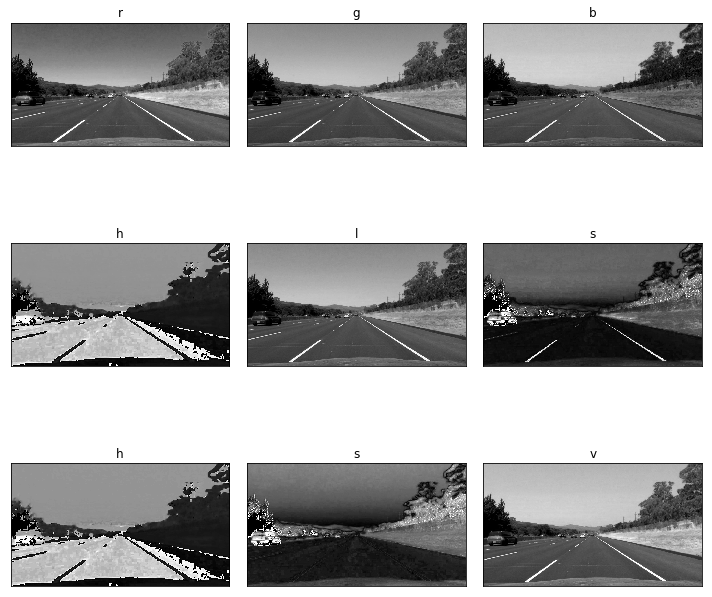

In [23]:
show_image_list(
    img_list=[
        rgb(undistorted_image, 'r'), rgb(undistorted_image, 'g'), rgb(undistorted_image, 'b'), 
        hls(undistorted_image, 'h'), hls(undistorted_image, 'l'), hls(undistorted_image, 's'), 
        hsv(undistorted_image, 'h'), hsv(undistorted_image, 's'), hsv(undistorted_image, 'v')
    ],
    img_labels=[
        'r', 'g', 'b',
        'h', 'l', 's', 
        'h', 's', 'v'
    ], 
    cmap='gray',
    cols=3
)

The **s**aturation channel from HLS looks best, we'll go with that.  

In [24]:
hls_s_image = hls(img=undistorted_image, channel='s')

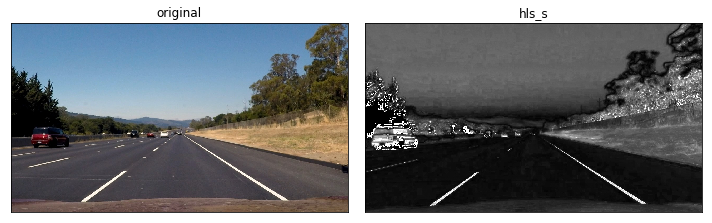

In [25]:
show_image_list(
    img_list=[
        test_image, hls_s_image, 
    ],
    img_labels=[
        'original', 'hls_s'
    ], 
    cmap='gray',
    cols=2
)

Another advantage of the S channel in HLS that we don't show here is that it is very robust to changing conditions. We'll see in our videos later that lane lines that are overshadowed will also be picked up in this color space.   

---

## Step 3: Gaussian blur

Gaussian blur is a commonly used pre-processing technique that does exactly what it sounds like it does.   

<figure>
 <img src="writeup_images/gaussian_blur.png"/>
 <figcaption>
 <p></p>  
     
We're going to use Gaussian blur to reduce the number of edges we detect later on. We have to be careful though. Too much blurring and it will become difficult to find any lines. We can control the amount of blurring by adjusting our kernel size.  

In [26]:
def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [27]:
blur_image = gaussian_blur(hls_s_image)

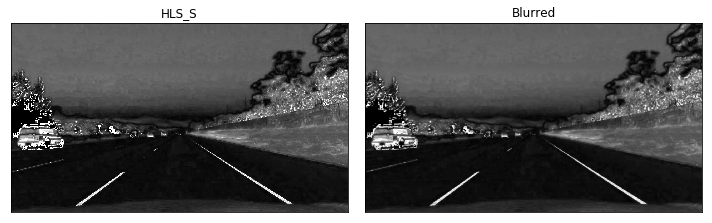

In [28]:
show_image_list(
    img_list=[
        hls_s_image, blur_image, 
    ],
    img_labels=[
        'HLS_S', 'Blurred'
    ], 
    cmap='gray',
    cols=2
)

Although its a little difficult to see here, the sharp jagged edges of our lane lines have become smoother, ergo more continuous. This should help in a few stages when we try to detect edges.  

---

## Step 4: Thresholding

Thresholding is one of the most basic approaches to image segmentation. Essentially, it involves turning pixels on/off based on whether a pixel property satisfies a given threshold condition. The end result are **binary** images, which by definition contain significantly less noise.   

Below we explore a number of thresholding approaches.  

### Color thresholding  

Color thresholding is the easiest to understand. We've already explored thresholding individual RGB/HLS/HSV color channels. This time we'll threshold pixel values in our given channel. 

So for example, if we say we want to threshold for pixel values above 250 in an image, this means we  only want to retain pixels where the pixel value is greater than 250. In effect, we would end up retaining only the white elements of an image. Note that this isn't necessarily what we want given that lane lines can also be yellow.  

In [29]:
def color_threshold(img, thresh=(50, 255)):
    """
    thresholds a given single channel image
    """
    
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    
    return binary_output

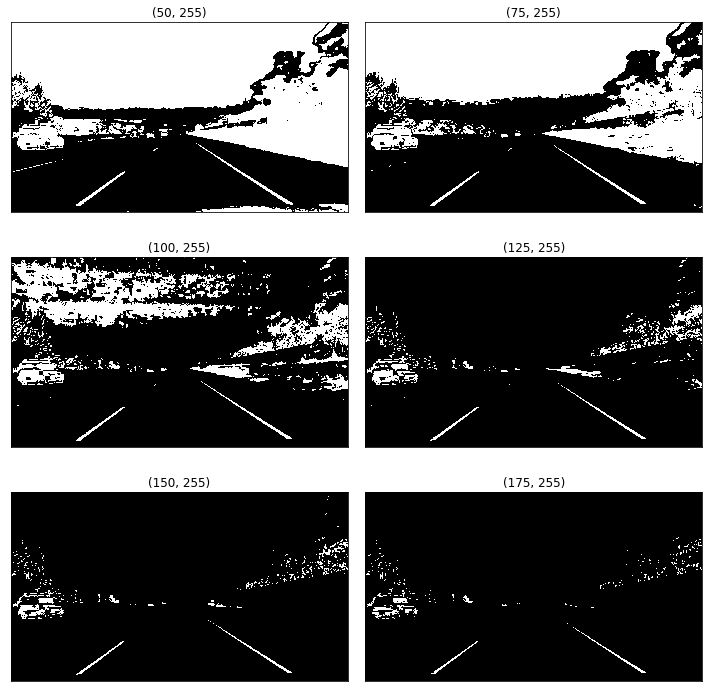

In [30]:
thresholds=[
    (50, 255),
    (75, 255),
    (100, 255),
    (125, 255),
    (150, 255),
    (175, 255)
    ]

show_image_list(
    img_list=[color_threshold(blur_image, threshold) for threshold in thresholds],
    img_labels=thresholds, 
    cmap='gray',
    cols=2
)

All of these settings look perfectly decent for extracting the lane line on the left. The lane line on the right however shows up most clearly under the (50, 255) setting.  

As a note, you can see that the background noise is affected more by this setting. We're not too concerned with removing background noise though since we will just crop this out later as its not within our region of interest.  

### Gradient thresholding  

Applying the Sobel operator to an image is a way of taking the derivative (i.e. gradient) of the image in the x or y direction. 

One way of thinking about how these operators work is to imagine a small window overlaid over a portion of your image. If the image is flat across that region, then the result will be zero. If, instead, for example, you apply the Sobelx operator to a region of the image where values are rising from left to right, then the result will be positive, implying a positive derivative in the x direction. In reality, you're summing the element-wise product of the sobel operator and the corresponding image pixels of the window under consideration.  

We'll try applying the sobel operator with the x-gradient first.   

In [31]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    expects a single channel image
    sobel_kernel must be an odd number, choose a larger odd number to smooth gradient measurements 
    """
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x': 
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

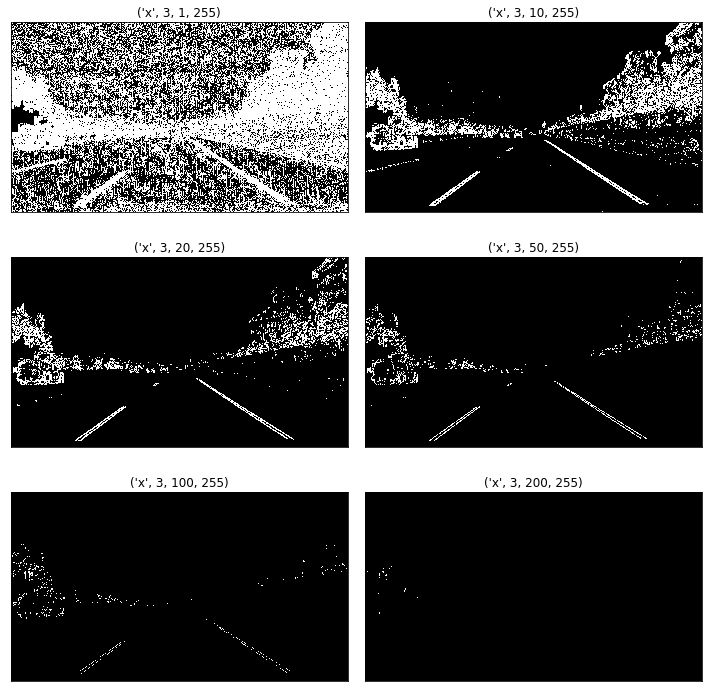

In [32]:
params=[
    ('x', 3, 1, 255),
    ('x', 3, 10, 255),
    ('x', 3, 20, 255),
    
    ('x', 3, 50, 255),
    ('x', 3, 100, 255),
    ('x', 3, 200, 255)
    ]

show_image_list(
    img_list=[
        abs_sobel_thresh(img = blur_image, 
                         orient = param[0], 
                         sobel_kernel = param[1], 
                         thresh = (param[2], param[3])
                        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=2
)

Let's try again using the 'y' gradient.  

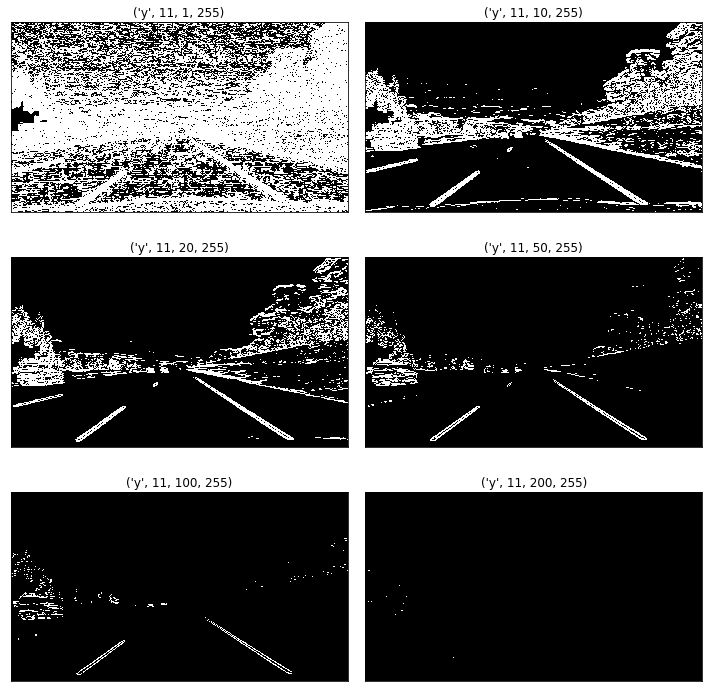

In [33]:
params=[
    ('y', 11, 1, 255),
    ('y', 11, 10, 255),
    ('y', 11, 20, 255),
    
    ('y', 11, 50, 255),
    ('y', 11, 100, 255),
    ('y', 11, 200, 255)
    ]

show_image_list(
    img_list=[
        abs_sobel_thresh(
            img = blur_image, 
            orient = param[0], 
            sobel_kernel = param[1], 
            thresh = (param[2], param[3])
            ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=2
)

You can see that the x-gradient does a "cleaner" job of picking up the lane lines, but you can see the lines in the y-gradient as well. A combination of the two is likely to work well then.  

### Magnitude thresholding  

This time we'll try applying threshold to the overall magnitude of the gradient, in both the x and y direction.  

In [34]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    """
    expects a single channel image
    sobel_kernel must be an odd number, choose a larger odd number to smooth gradient measurements
    """
    
    # Take the derivative in x and y
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the derivative or gradient
    abs_sobel_xy = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_xy/np.max(abs_sobel_xy))
    
    # Create a mask of 1's where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary

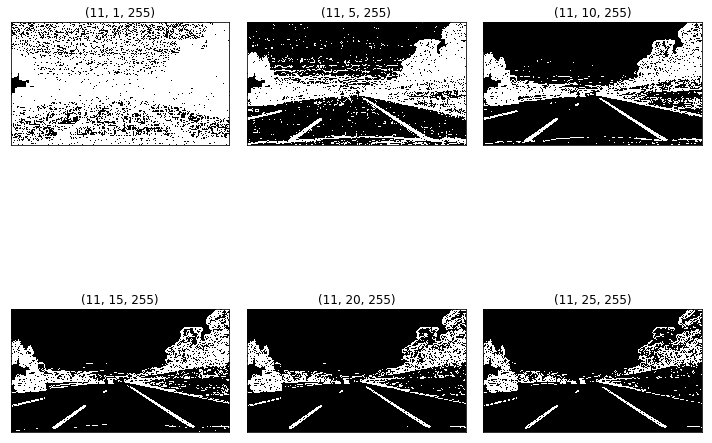

In [35]:
params=[
    (11, 1, 255),
    (11, 5, 255),
    (11, 10, 255),
    (11, 15, 255),
    (11, 20, 255),
    (11, 25, 255),
    ]

show_image_list(
    img_list=[
        mag_threshold(
            img = blur_image, 
            sobel_kernel = param[0], 
            thresh = (param[1], param[2])
        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=3
)

Background-wise, we're getting noisier results than we did with color thresholding. That said we get the lane lines on both sides picked up very well under any off the above settings. As a note, gradient magnitude is at the heart of Canny edge detection, and is why Canny works well for picking up all edges.  

### Direction thresholding  

If you think about it, in the case of lane lines we're really only interested in edges of a particular orientation. The direction of the gradient is simply the inverse tangent (arctangent) of the y gradient divided by the x gradient:

arctan(sobel y/sobel x)   

Each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians, covering a range of −π/2 to π/2. An orientation of 0 implies a horizontal line and orientations of +/−π/2 imply vertical lines.  

In [36]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    expects a single channel image
    sobel_kernel must be an odd number, choose a larger odd number to smooth gradient measurements
    """
    
    # Take the derivative in x and y
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # Calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Create a mask of where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    return dir_binary

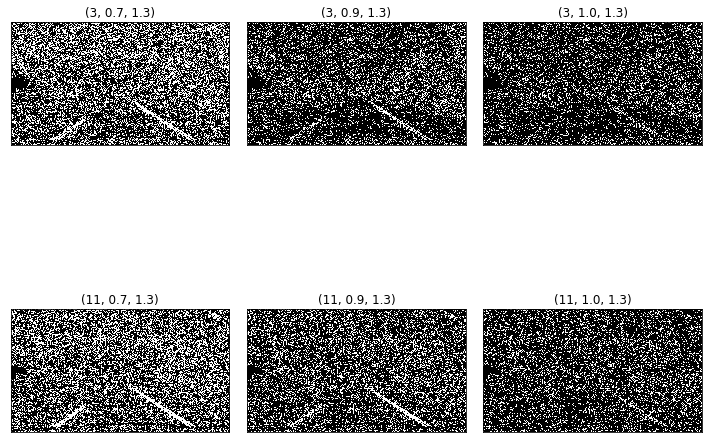

In [37]:
params=[
    (3, 0.7, 1.3),
    (3, 0.9, 1.3),
    (3, 1.0, 1.3),
    (11, 0.7, 1.3),
    (11, 0.9, 1.3),
    (11, 1.0, 1.3),
    ]

show_image_list(
    img_list=[
        dir_threshold(
            img = blur_image, 
            sobel_kernel = param[0], 
            thresh = (param[1], param[2])
        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=3
)

Getting some really noisy images. You can see the left lane line in some of these images but the right lane line isn't obvious in the noise.  

### Combining multiple thresholds  

At this point, we have a number of thresholding techniques in our arsenal. Some work better than others. Instead of using just one of them, we can combine multiple thresholds using AND and OR operations.  

In [38]:
def combine_thresholds(images): 
    """
    combines images thresholded in different ways
    """
    
    combined = np.zeros_like(images[1])
    
    length = len(images)
    
    if length==2:
        combined[(images[0]==1) & 
                 (images[1]==1)
                ] = 1
        
    if length==3:
        combined[(images[0]==1) & 
                 (images[1]==1) &
                 (images[2]==1)
                ] = 1
        
    if length==4:
        combined[(images[0]==1) & 
                 (images[1]==1) &
                 (images[2]==1) &
                 (images[3]==1)
                ] = 1
        
    if length==5:
        combined[(images[0]==1) & 
                 (images[1]==1) &
                 (images[2]==1) &
                 (images[3]==1) &
                 (images[4]==1)
                ] = 1
        
    return combined

We'll stick with color_threshold and mag_threshold as those seemed to give the clearest lane line results.  

In [39]:
params=[
    color_threshold(
        img=blur_image, 
        thresh=(50,255)
    ), 
#      abs_sobel_thresh(
#         img = blur_image, 
#         orient = 'y', 
#         sobel_kernel = 11, 
#         thresh = (10, 255)
#     ), 
     mag_threshold(
         img = blur_image, 
         sobel_kernel = 11, 
         thresh = (10, 255)
     ), 
#      dir_threshold(
#          img = blur_image, 
#          sobel_kernel = 9, 
#          thresh = (0.7, 1.3)
#      )
    
]

# show_image_list(
#     img_list=[
#         combine_thresholds(
#             images = [param for param in params]
#         )
#     ],
#     img_labels=['Preprocessed' for param in params], 
#     cmap='gray',
#     cols=1
# )

In [40]:
threshold_image = combine_thresholds(
    images = [param for param in params]
)

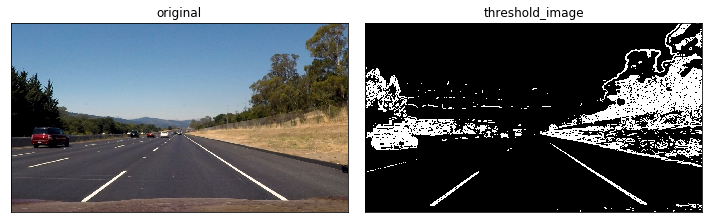

In [41]:
show_image_list(
    img_list=[
        test_image, threshold_image, 
    ],
    img_labels=[
        'original', 'threshold_image'
    ], 
    cmap='gray',
    cols=2
)

This is looking pretty good.  

## Step 5: Perspective Transform  

The image we have has been de-noised pretty well to extract the lane lines. We can now officially start thinking about finding lane lines. 

Because of where our camera is placed, we have a front-facing view, or perspective, of the road. This means that the lane in front of us looks smaller the further away it gets from our camera. 

Perspective transform is a technique for warping an image to get different views or perspectives. It would be useful for us if we could zoom in on the further away objects in our image, i.e. get a top-down view of the road. Some of our tasks later on will be easier to perform on this kind of view. 

For example, fitting a line and calculating the lane curvature will be easier with this view later on. Currently you'll notice that the left lane line is leaning towards the right in our test image. The right lane line is leaning towards the left. In fact, in the image it looks like the two lane lines will eventually converge. However, the reality is that they are both parallel. A top down perspective transform will show as much.  

Although not relevant for this project, this perspective is also useful for matching up a car's location with a map.  

Applying a perspective transform is very similar to what we did for undistorting an image. The only difference is that tnstead of mapping object points to image points, this time we'll be mapping points on an image to different desired points on an image with a new perspective.  

It should be noted that perspective transforms can be used for more than just creating a bird’s eye view representation of an image. You could get a side angle view for example. Again, this is not relevant for our project.      

<figure>
 <img src="writeup_images/perspective_transform.jpg"/>
 <figcaption>
 <p></p>  
     
First, we need to figure out what 4 points we want to warp our image about.  

In [42]:
# define a trapezoidal region of interest about our lane

# where we want our trapezoid to start and end along the y axis
min_y = 720
max_y = 455

# define x,y for 4 points
left_x1 = 190 
left_y1 = min_y

left_x2 = 585
left_y2 = max_y

right_x1 = 705
right_y1 = max_y

right_x2 = 1130
right_y2 = min_y

# define array of 4 points
# the order matters!
# first entry is the top-left
# second entry is the top-right
# third is the bottom-right
# fourth is the bottom-left

src = np.float32([ 
    [left_x2, left_y2],
    [right_x1, right_y1],
    [right_x2, right_y2],
    [left_x1, left_y1]
])

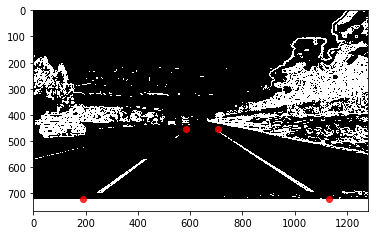

In [43]:
w, h = threshold_image.shape

# temp copy of image
temp = threshold_image.copy()

color = [255, 0, 0]
thickness = 10

# add lines
cv2.line(
    img = temp, 
    pt1 = (left_x1, left_y1), 
    pt2 = (left_x2, left_y2), 
    color = color, 
    thickness = thickness
)

cv2.line(
    img = temp, 
    pt1 = (left_x2, left_y2), 
    pt2 = (right_x1, right_y1), 
    color = color, 
    thickness = thickness
)

cv2.line(
    img = temp, 
    pt1 = (right_x1, right_y1), 
    pt2 = (right_x2, right_y2), 
    color = color, 
    thickness = thickness
)

cv2.line(
    img = temp, 
    pt1 = (right_x2, right_y2), 
    pt2 = (left_x1, left_y1), 
    color = color, 
    thickness = thickness
)

plt.imshow(threshold_image, cmap='gray')
plt.scatter(src[:,0], src[:,1], color='red', alpha = 0.8)

Define a matching set of 4 (destination) points for our new (warped) image.  

In [44]:
w = threshold_image.shape[1]
h = threshold_image.shape[0]

# offset from the sides
offset = 200

# first entry is the top-left
# second entry is the top-right
# third is the bottom-right
# fourth is the bottom-left
dst = np.float32([
    [offset, 0],
    [w - offset, 0],
    [w - offset, h], 
    [offset, h]
])

In [45]:
# Compute the perspective transform, M, given source and destination points
M = cv2.getPerspectiveTransform(src, dst)

# Compute the inverse perspective transform
# We will need this later on when we want to 'unwarp' our image
Minv = cv2.getPerspectiveTransform(dst, src)

In [46]:
def adjustPerspective(img, M):
    """
    Adjust an image's perspective using the transformation matrix M
    """
    
    img_size = (img.shape[1], img.shape[0])
    
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

In [47]:
warped = adjustPerspective(
    img=threshold_image
    , M=M
)

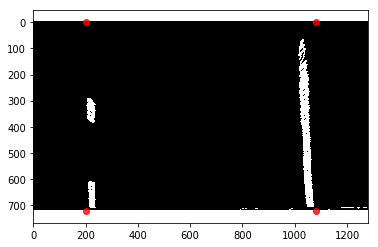

In [48]:
plt.imshow(warped, cmap='gray')
plt.scatter(dst[:,0], dst[:,1], color='red', alpha = 0.8)

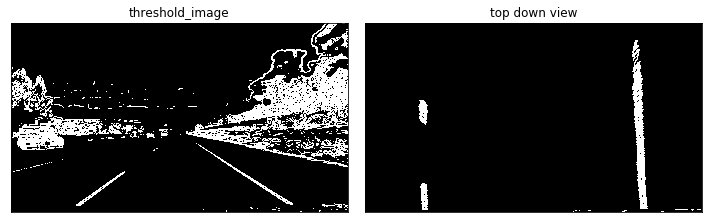

In [49]:
show_image_list(
    img_list=[
        threshold_image, warped, 
    ],
    img_labels=[
        'threshold_image', 'top down view'
    ], 
    cmap='gray',
    cols=2
)

Ta-da, we have a top down view. There's still a little bit of noise we need to account for.  

## Step 6: Detect lane line pixels

We now have a thresholded warped image. We can now actually start mapping out the lane lines! We're going to try a number of ways to do this. 

### Peaks in a histogram

We have a binary image where the lane lines stand out pretty clearly. However, we still need to decide explicitly which pixels are part of which lane line (if any).    

One way of doing this is using a histogram-like approach of the total of the pixel values in each 'column' of pixels.   

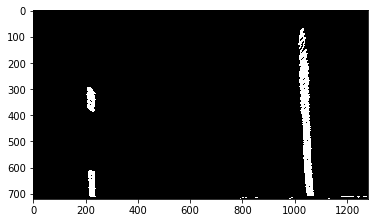

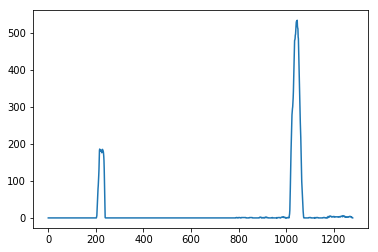

In [50]:
window = np.ones(35)

plt.imshow(warped, cmap='gray')
plt.show()

total_sum = np.sum(warped, axis=0)
plt.plot(total_sum)
plt.show()

Notice how the histogram peaks at exactly the same range of x values as our lane line pixels. This is because in our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x coordinates of the base of the lane lines. We will use these as starting points for where to search for the lane lines. 

Now we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.  

In [51]:
def fit_lane_lines(img, nwindows=9):
    """
    Arguments: 
        img: 
            must be binary
            must show a top down view of road
        nwindows: 
            number of sliding windows to use
    Returns: 
        left_fit: 
        right_fit:
    """

    # Assuming you have created a warped binary image called "img"
    # Take a histogram of the bottom half of the image
    # why bottom half? Cause lane line could be curving
    # and all we want to figure out is where to start drawing 
    # our lane lines from at the bottom of the image
    # this isn't using any histogram function
    # all its doing is returning an (ordered) array of the sum of each column in our image
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting points for our left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # determine based on where we have the most pixels in a column
    # best_defined_lane = np.argmax(histogram)

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(
            out_img,
            (win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),
            (0,255,0), 
            2
        ) 

        cv2.rectangle(
            out_img,
            (win_xright_low,win_y_low),
            (win_xright_high,win_y_high),
            (0,255,0), 
            2
        ) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (
            (nonzeroy >= win_y_low) 
            & (nonzeroy < win_y_high) 
            & (nonzerox >= win_xleft_low) 
            & (nonzerox < win_xleft_high)
        ).nonzero()[0]

        good_right_inds = (
            (nonzeroy >= win_y_low) 
            & (nonzeroy < win_y_high) 
            & (nonzerox >= win_xright_low) 
            & (nonzerox < win_xright_high)
        ).nonzero()[0] 

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Set minimum number of pixels found to create a line
    # if a lane is curving this might be too extreme
    # TODO: look for number of pixels in a range of adjacent x bins
#     min_line_pix = 300
    
#     # if the number of pixels in a given lane is too low to get a good line
#     # use other lane if that is better
#     if (histogram[rightx_base] < min_line_pix) & (histogram[leftx_base] > min_line_pix): 
#         rightx = leftx + (midpoint + leftx_base)
#         righty = lefty

#     if (histogram[leftx_base] < min_line_pix) & (histogram[rightx_base] > min_line_pix): 
#         leftx = np.repeat(midpoint, rightx.size) - (rightx_base - midpoint)
#         lefty = righty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    color = (255,255,255)
    
    # get points for drawing
    left_pts = (list(zip(left_fitx, ploty)))
    right_pts = (list(zip(right_fitx, ploty)))
        
    return left_pts, right_pts, out_img

In [52]:
def draw_lane_line(img, pts): 
    
    cv2.polylines(
        img,
        [np.int32(pts)],
        False,
        color, 
        10
    )

    return img

In [53]:
def draw_both_lane_lines(warped_img, left_pts, right_pts):
    
    detected_left_lane = draw_lane_line(img=warped_img, pts = left_pts)
    detected_right_lane = draw_lane_line(img=warped_img, pts = right_pts)
    
    detected_both_lanes = cv2.addWeighted(
        detected_left_lane, 
        0.5, 
        detected_right_lane, 
        0.5, 
        0
    )
    
    return detected_both_lanes

In [54]:
left_pts, right_pts, out_img = fit_lane_lines(img=warped)

detected_both_lanes = draw_both_lane_lines(out_img.copy(), left_pts, right_pts)

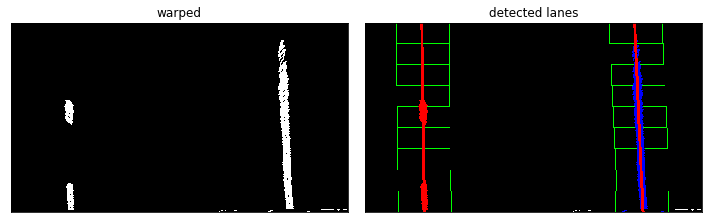

In [55]:
show_image_list(
    img_list=[
        warped, detected_both_lanes 
    ],
    img_labels=[
        'warped', 'detected lanes'
    ], 
    cmap='gray',
    cols=2
)

---
## Step 8: Overlay detection on original image

That's the hard stuff done. Now we just need to unwarp our detections and overlay this over the original image.  

We'll also some calculations for curvature and centre offset.  

In [56]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [57]:
def calc_lane_line_coefficients(
    left_pts, 
    right_pts, 
    space='p'
    ): 
    """
    Get lane line coefficients

    Arguments: 
        space: 
            pixel space ('p') or real world space ('m' as metres)
    """

    leftx = np.array([coordinate[0] for coordinate in left_pts])
    lefty = np.array([coordinate[1] for coordinate in left_pts])
    
    rightx = np.array([coordinate[0] for coordinate in right_pts])
    righty = np.array([coordinate[1] for coordinate in right_pts])
    
    # Fit a second order polynomial to each in pixel space
    if space=='p': 
        left_coefficients = np.polyfit(lefty, leftx, 2)
        right_coefficients = np.polyfit(righty, rightx, 2)

     # Fit a second order polynomial to each in real world space (metres)
    elif space=='m': 
        left_coefficients = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_coefficients = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    return left_coefficients, right_coefficients

In [58]:
def calc_curvature(
    left_pts, 
    right_pts,
    y_eval, 
    ): 

    # Fit new polynomials to x,y in world space
    left_coefficients_m, right_coefficients_m = calc_lane_line_coefficients(
        left_pts, 
        right_pts, 
        space='m'
    )

    # Calculate the new radii of curvature
    left_curve_rad = ((1 + (2*left_coefficients_m[0]*y_eval*ym_per_pix + left_coefficients_m[1])**2)**1.5) / np.absolute(2*left_coefficients_m[0])
    right_curve_rad = ((1 + (2*right_coefficients_m[0]*y_eval*ym_per_pix + right_coefficients_m[1])**2)**1.5) / np.absolute(2*right_coefficients_m[0])

    return left_curve_rad, right_curve_rad

In [59]:
def calc_offset_from_center(
    left_pts, 
    right_pts
    ):
    
    leftx = np.array([coordinate[0] for coordinate in left_pts])
    lefty = np.array([coordinate[1] for coordinate in left_pts])
    
    rightx = np.array([coordinate[0] for coordinate in right_pts])
    righty = np.array([coordinate[1] for coordinate in right_pts])

    left_offset = (leftx[0] - 320) * xm_per_pix
    right_offset = (rightx[0] - 960) * xm_per_pix

    return (left_offset + right_offset) / 2

In [60]:
def draw_lane_with_info(
    og_img, 
    binary_warped_img, 
    Minv
    ):
    """
    Draw the lane lines on the image and radius information
    """   
    
    left_pts, right_pts, out_img = fit_lane_lines(img=binary_warped_img)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_pts_fillPoly = np.array(left_pts)
    right_pts_fillPoly = np.flipud(np.array(right_pts))
    pts_fillPoly = np.vstack((left_pts_fillPoly, right_pts_fillPoly))

    # Draw the lane onto the warped blank image
    color_warp = np.zeros_like(og_img).astype(np.uint8)
    cv2.fillPoly(color_warp, np.int_([pts_fillPoly]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (og_img.shape[1], og_img.shape[0]))

    # add unwarped lane to image
    result = cv2.addWeighted(og_img, 1, newwarp, 0.3, 0)
    
    # calculate curvature
    left_curve_rad, right_curve_rad = calc_curvature(
        left_pts = left_pts,
        right_pts = right_pts,  
        y_eval = og_img.shape[0]/2, # y max value 
    )

    # add curvature to image
    cv2.putText(
        img = result, 
        text = ("Radius of left curvature: %s" %round(left_curve_rad, 0)), 
        org = (25,50), 
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
        fontScale = 1, 
        color = [255, 255, 255], 
        thickness = 5
    )

    cv2.putText(
        img = result, 
        text = ("Radius of right curvature: %s" %round(right_curve_rad, 0)), 
        org = (25,100), 
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
        fontScale = 1, 
        color = [255, 255, 255], 
        thickness = 5
    )


    # calculate centre offset
    offset = calc_offset_from_center(
        left_pts, 
        right_pts
    )

    # add vehicle position wrt to left lane to image
    cv2.putText(
        img = result, 
        text = ("Vehicle is %sm left of the center" %round(offset, 2)), 
        org = (20,150), 
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
        fontScale = 1, 
        color = [255, 255, 255], 
        thickness = 5
    )

    return result

In [61]:
lane_identified = draw_lane_with_info(test_image.copy(), warped.copy(), Minv)

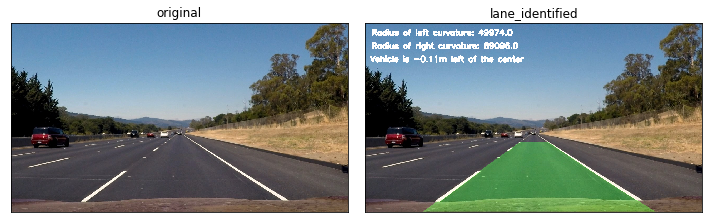

In [62]:
show_image_list(
    img_list=[
        test_image, lane_identified, 
    ],
    img_labels=[
        'original', 'lane_identified'
    ], 
    cmap='gray',
    cols=2
)

## Testing on images

Now let's combine all of the above functions into one with our best parameters.  

In [63]:
original_images = list(
    map(lambda img: load_image(img), 
        original_image_names)
)

# show_image_list(img_list = original_images)

In [64]:
def process_image(img):
    """
    One function to rule them all!
    """
    
    # undistory image 
    undistorted_image = undistort(img.copy(), mtx, dist)
    
    # convert image to hsl
    hls_s_image = hls(img=undistorted_image, channel='s')
    
    # apply Gaussian smoothing
    # blur_image = gaussian_blur(hls_s_image)
    
    # threshold image
    color_threshold_image = color_threshold(
        img=hls_s_image, 
        thresh=(50,255)
    )
    
    mag_threshold_image = mag_threshold(
        img = hls_s_image, 
        sobel_kernel = 11, 
        thresh = (10, 255)
    )
    
    threshold_image = combine_thresholds(
        images = [color_threshold_image, mag_threshold_image]
    )
    
    # warp perspective to top down view
    warped_image = adjustPerspective(threshold_image, M)
    
    # lane on image
    final_image = draw_lane_with_info(
        og_img=img.copy(), 
        binary_warped_img=warped_image, 
        Minv=Minv)

    return final_image

Lets test our function on all the images to see how well it worked.  

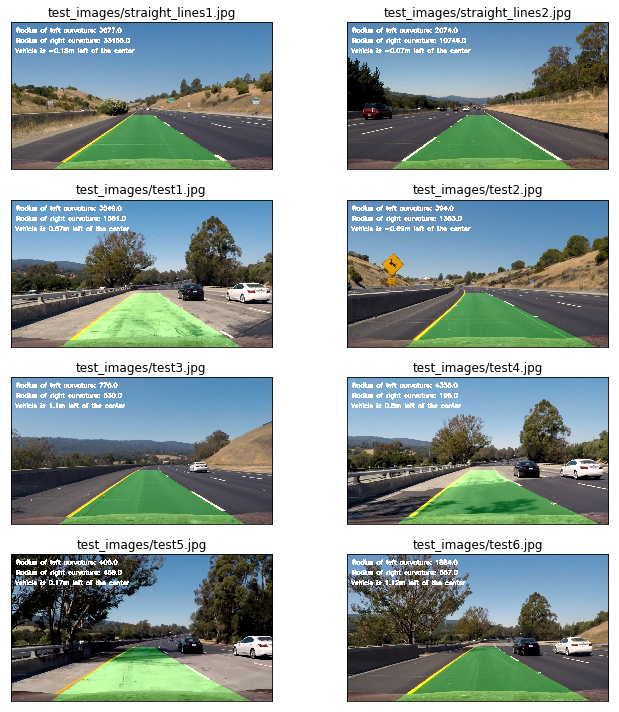

In [65]:
all_test_images = list(map(
    lambda img: process_image(img), 
    original_images
))

show_image_list(
    img_list=all_test_images
)

## Testing on videos

Drawing lanes over images is pretty cool but drawing lanes over video is awesome!

We'll test our solution on 3 different videos, ordered below by difficulty:

1. `project_video.mp4`

2. `challenge_video.mp4`

3. `harder_challenge_video.mp4`

In [66]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [67]:
def process_video(
    input_filepath, 
    output_filepath,
    video_filename,
    lane_detector, 
    plot=False
    ):
    
    video_input = VideoFileClip(input_filepath + video_filename)#.subclip(0,5)
    video_output = video_input.fl_image(lane_detector)
    video_output.write_videofile(output_filepath + video_filename , audio=False)
    
    return video_output

We'll try the one with the solid white lane on the right first. This is a fairly simple video. 

In [68]:
video_output = process_video(
    "test_videos/", 
    "output_videos/",
    "project_video.mp4", 
    process_image, 
    plot=False
)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [02:34<00:00,  8.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 



Now for the challenge video, one with the solid yellow lane on the left. This one's more tricky!

In [69]:
video_output = process_video(
    "test_videos/", 
    "output_videos/",
    "challenge_video.mp4", 
    process_image, 
    plot=False
)

TypeError: expected non-empty vector for x

Lastly, we'll try the harder challenge video.  

In [70]:
video_output = process_video(
    "test_videos/", 
    "output_videos/",
    "harder_challenge_video.mp4", 
    process_image, 
    plot=False
)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [02:41<00:00,  8.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

